<a href="https://colab.research.google.com/github/eikeschuett/IcebergShipDetection/blob/DNN_Trial_and_Error/CNN_test_different_speckle_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, import all required libraries

In [27]:
# Libraries to access files from my drive
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.optimizers import Adam

Then, import data from Google Drive. Code adapted from [here](https://www.roelpeters.be/how-to-uploading-files-in-google-colab/).

In [2]:
# Authenticate with Google
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def read_json_from_drive(file_id, file_name):
    dl = drive.CreateFile({'id': file_id})
    dl.GetContentFile(file_name)
    return pd.read_json(file_name)

df_train = read_json_from_drive('1WlrJpjbaMXEB5SrrlweDhXngBOJZHtyo', 'train.json')
print(df_train.head())

         id  ... is_iceberg
0  dfd5f913  ...          0
1  e25388fd  ...          0
2  58b2aaa0  ...          1
3  4cfc3a18  ...          0
4  271f93f4  ...          0

[5 rows x 5 columns]


Test different denoising filters and plot their results

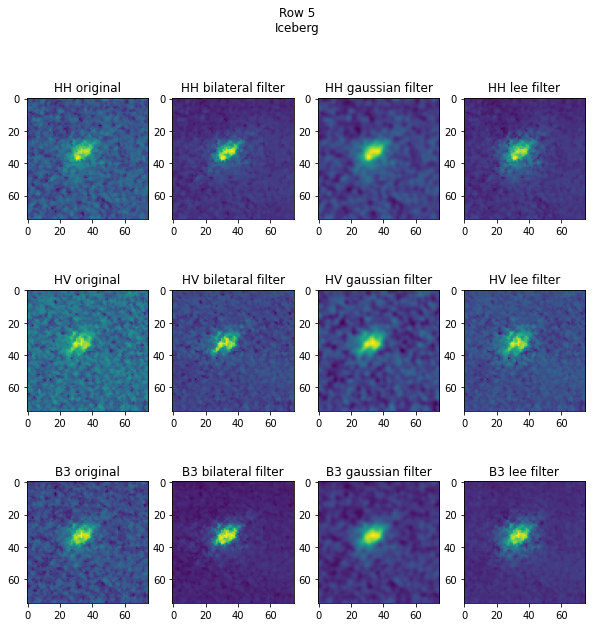

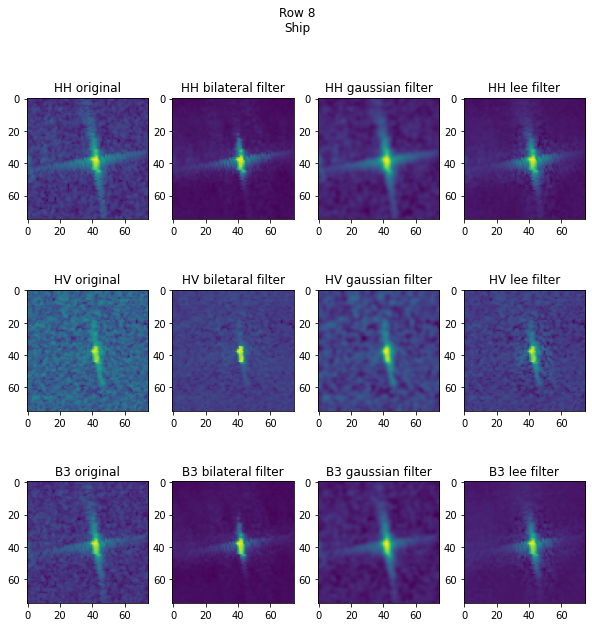

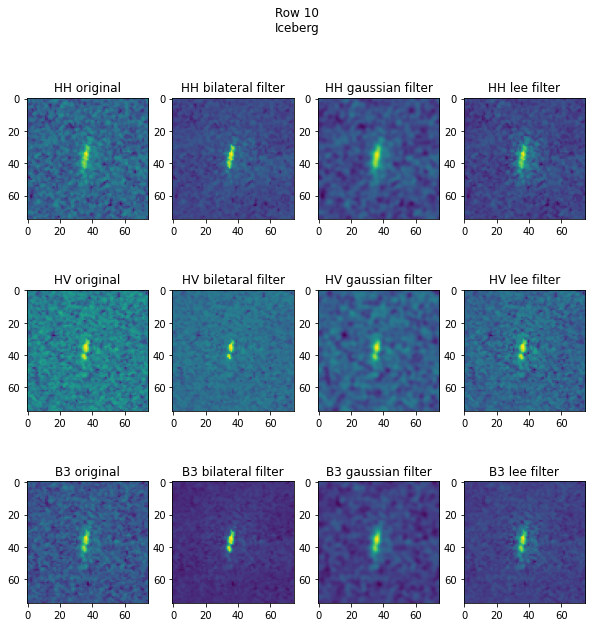

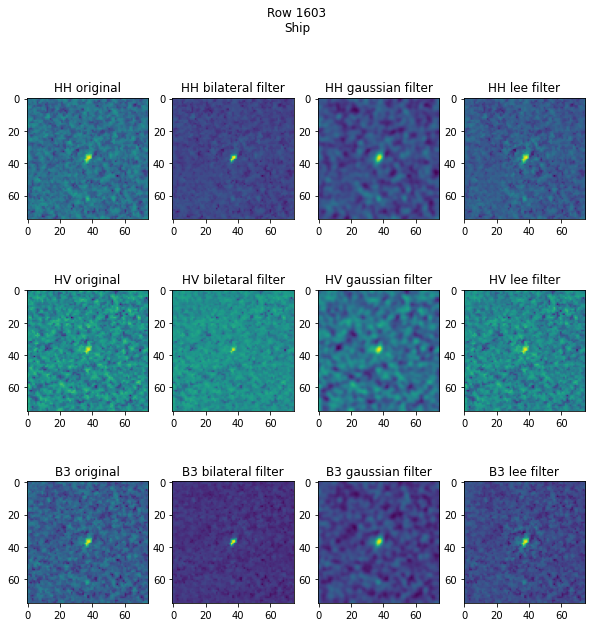

In [64]:
import matplotlib.pyplot as plt
from skimage.restoration import denoise_bilateral
from scipy import ndimage
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(img, size):
    # From here: https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output


for i in [5,8,10, 1603]: #, row in df_train.iterrows():
    row = df_train.loc[i,:]
    # Reshape list to image
    hh  = np.reshape(row["band_1"], (75, 75))
    hv  = np.reshape(row["band_2"], (75, 75))
    b3  = hh + hv

    # Rescale images between 0 and 1 for faster convergence rate
    hh = (hh - hh.min())/(hh.max()-hh.min())
    hv = (hv - hv.min())/(hv.max()-hv.min())
    b3 = (b3 - b3.min())/(b3.max()-b3.min())

    # Reduce noise
    hh_bil = denoise_bilateral(hh, sigma_color=0.10, sigma_spatial=5, mode="symmetric")
    hv_bil = denoise_bilateral(hv, sigma_color=0.10, sigma_spatial=5, mode="symmetric")
    b3_bil = denoise_bilateral(b3, sigma_color=0.10, sigma_spatial=5, mode="symmetric")

    hh_gau = ndimage.gaussian_filter(hh, 1)
    hv_gau = ndimage.gaussian_filter(hv, 1)
    b3_gau = ndimage.gaussian_filter(b3, 1)

    hh_lee = lee_filter(hh, 20)
    hv_lee = lee_filter(hv, 20)
    b3_lee = lee_filter(b3, 20)

    if df_train.loc[i,"is_iceberg"] == 0:
      target = "Ship"
    else:
      target = "Iceberg"

    fig, axs = plt.subplots(3, 4, figsize=(10,10))
    fig.suptitle("Row " + str(i) + "\n" + target)

    axs[0,0].imshow(hh)
    axs[0,0].set_title("HH original")

    axs[0,1].imshow(hh_bil)
    axs[0,1].set_title("HH bilateral filter")

    axs[0,2].imshow(hh_gau)
    axs[0,2].set_title("HH gaussian filter")

    axs[0,3].imshow(hh_lee)
    axs[0,3].set_title("HH lee filter")    

    axs[1,0].imshow(hv)
    axs[1,0].set_title("HV original")

    axs[1,1].imshow(hv_bil)
    axs[1,1].set_title("HV biletaral filter")

    axs[1,2].imshow(hv_gau)
    axs[1,2].set_title("HV gaussian filter")

    axs[1,3].imshow(hv_lee)
    axs[1,3].set_title("HV lee filter")        

    axs[2,0].imshow(b3)
    axs[2,0].set_title("B3 original")
    
    axs[2,1].imshow(b3_bil)
    axs[2,1].set_title("B3 bilateral filter")

    axs[2,2].imshow(b3_gau)
    axs[2,2].set_title("B3 gaussian filter")

    axs[2,3].imshow(b3_lee)
    axs[2,3].set_title("B3 lee filter")        

    plt.show()
    # if i == 2:
    #   break




Prepare the training and validation data for the model

In [84]:
def prepare_data(df_train, filter):
  df_train["inc_angle"] = df_train["inc_angle"].replace(["na"], np.nan)

  # Get the labels (y-values)
  labels = np.array(df_train["is_iceberg"])

  # Create empty list for the images
  imgs = []
  for i, row in df_train.iterrows():
      # Reshape list to image
      hh  = np.reshape(row["band_1"], (75, 75))
      hv  = np.reshape(row["band_2"], (75, 75))
      b3  = hh + hv
      
      # Rescale images between 0 and 1 for faster convergence rate
      hh = (hh - hh.min())/(hh.max()-hh.min())
      hv = (hv - hv.min())/(hv.max()-hv.min())
      b3 = (b3 - b3.min())/(b3.max()-b3.min())

      if filter == "bilateral":
        # Denoise images with bilteral fitler
        hh = denoise_bilateral(hh, sigma_color=0.10, sigma_spatial=5)
        hv = denoise_bilateral(hv, sigma_color=0.10, sigma_spatial=5)
        b3 = denoise_bilateral(b3, sigma_color=0.10, sigma_spatial=5)
      elif filter == "lee":
        hh = lee_filter(hh, 20)
        hv = lee_filter(hv, 20)
        b3 = lee_filter(b3, 20)
      elif filter == "gaussian":
        hh = ndimage.gaussian_filter(hh, 1)
        hv = ndimage.gaussian_filter(hv, 1)
        b3 = ndimage.gaussian_filter(b3, 1)
      

      # Stack the bands and append them to imgs
      imgs.append(np.dstack((hh, hv, b3)))
      # print(i)
  # Split dataset into training and test data
  x_train, x_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.25, random_state=42)
  x_train = np.array(x_train)
  x_test = np.array(x_test)
  return x_train, x_test, y_train, y_test

Set up DataGenerators

In [85]:
def DataGenerators(x_train, x_test, y_train, y_test):
  training_datagen = ImageDataGenerator(
      rotation_range = 90,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True,
      fill_mode = 'nearest')#,
      #validation_split = 0.2)

  train_generator = training_datagen.flow(x_train, y_train)#,
                                      #batch_size=64)#, 
                                      #subset = "training")

  val_datagen = ImageDataGenerator()

  val_generator = val_datagen.flow(x_test, y_test)#,
                                      #batch_size=16)#, 
                                      #subset = "training")
  
  return train_generator, val_generator


Set up and compile model

In [86]:
def model_setup():
  model = tf.keras.models.Sequential([
      # Note the input shape is the desired size of the image 75x75 with 3 bytes color
      # This is the first convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(75, 75, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.2),
      # The second convolution
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.1),
      # The third convolution
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.1),
      # The fourth convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.2),
      # Flatten the results to feed into a DNN
      tf.keras.layers.Flatten(),
      # 512 neuron hidden layer
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.BatchNormalization(renorm=True),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      #tf.keras.layers.Dense(128, activation='relu'),
      # Only 1 output neuron. It will contain a value from 0-1 where 0 means ship and 1 means iceberg
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  # print(model.summary())
  model.compile(loss='binary_crossentropy',
                optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                metrics=['accuracy'])
  return model

Train model

In [88]:
def run_model(model):
  history = model.fit(
        train_generator,
        #steps_per_epoch=10,  
        epochs=200,
        verbose=1,
        validation_data = val_generator)#,
        #validation_steps=10)
  return history

Run model for different filters

In [90]:
# no filter
x_train, x_test, y_train, y_test = prepare_data(df_train, None)
train_generator, val_generator = DataGenerators(x_train, x_test, y_train, y_test)
model = model_setup()
history_nofilter = run_model(model)

# Lee filter
x_train, x_test, y_train, y_test = prepare_data(df_train, "lee")
train_generator, val_generator = DataGenerators(x_train, x_test, y_train, y_test)
model = model_setup()
history_lee = run_model(model)

# Gaussian filter
x_train, x_test, y_train, y_test = prepare_data(df_train, "gaussian")
train_generator, val_generator = DataGenerators(x_train, x_test, y_train, y_test)
model = model_setup()
history_gaussian = run_model(model)

# bilateral
x_train, x_test, y_train, y_test = prepare_data(df_train, "bilateral")
train_generator, val_generator = DataGenerators(x_train, x_test, y_train, y_test)
model = model_setup()
history_bilateral = run_model(model)

Epoch 1/200
38/38 [==============================] - 3s 60ms/step - loss: 0.6908 - accuracy: 0.5447 - val_loss: 0.6900 - val_accuracy: 0.4888
Epoch 2/200
38/38 [==============================] - 2s 65ms/step - loss: 0.6912 - accuracy: 0.4962 - val_loss: 0.6814 - val_accuracy: 0.5362
Epoch 3/200
38/38 [==============================] - 2s 56ms/step - loss: 0.6740 - accuracy: 0.6155 - val_loss: 0.6604 - val_accuracy: 0.6983
Epoch 4/200
38/38 [==============================] - 2s 55ms/step - loss: 0.6670 - accuracy: 0.6349 - val_loss: 0.6259 - val_accuracy: 0.7257
Epoch 5/200
38/38 [==============================] - 2s 56ms/step - loss: 0.6254 - accuracy: 0.6678 - val_loss: 0.6205 - val_accuracy: 0.6708
Epoch 6/200
38/38 [==============================] - 2s 57ms/step - loss: 0.5929 - accuracy: 0.6803 - val_loss: 0.5963 - val_accuracy: 0.6409
Epoch 7/200
38/38 [==============================] - 2s 57ms/step - loss: 0.5948 - accuracy: 0.6644 - val_loss: 0.5429 - val_accuracy: 0.7406
Epoch 

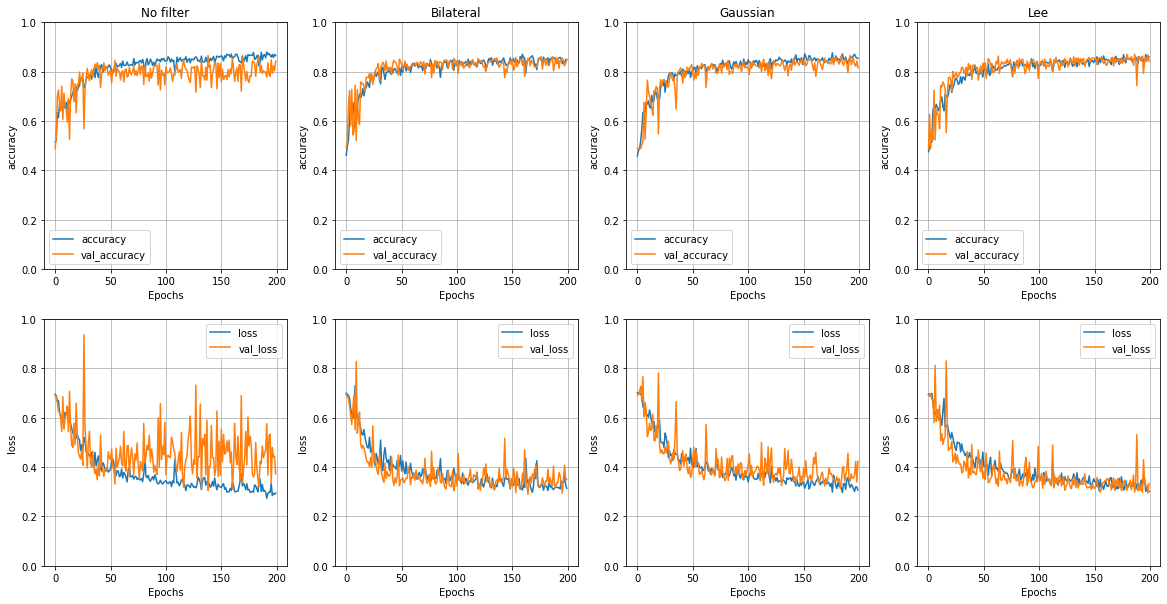

In [126]:
def plot_graphs(history, string, x, y, n, label):
  fig.add_subplot(x,y,n)
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.ylim([0,1])
  plt.grid()
  if string=="accuracy":
    plt.title(label)
  #plt.show()
  
fig = plt.figure(figsize=(20,10))
plot_graphs(history_nofilter, "accuracy", 2, 4, 1, "No filter")
plot_graphs(history_bilateral, "accuracy", 2, 4, 2, "Bilateral")
plot_graphs(history_gaussian, "accuracy", 2, 4, 3, "Gaussian")
plot_graphs(history_lee, "accuracy", 2, 4, 4, "Lee")

plot_graphs(history_nofilter, "loss", 2, 4, 5, "No filter")
plot_graphs(history_bilateral, "loss", 2, 4, 6, "Bilateral")
plot_graphs(history_gaussian, "loss", 2, 4, 7, "Gaussian")
plot_graphs(history_lee, "loss", 2, 4, 8, "Lee")


